In [1]:
## This version is multiplied from version 2 after reducing. 

# Initial 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from scipy.integrate import odeint,quad
from scipy.stats import kde,beta
import seaborn as sns
from importlib import reload
pi=np.pi
from scipy.optimize import brentq

#from numpy import linalg as LA
from scipy.linalg import expm # calculate the exponential matrix.
from scipy.linalg import eig

import seaborn as sns
from importlib import reload
pi=np.pi
from scipy.optimize import brentq
from numpy import linalg as LA
from scipy.linalg import expm
from scipy import interpolate
from scipy.integrate import quad, dblquad
from scipy import integrate

\begin{aligned}
    \frac{\text{d}S_H}{\text{d}t} &= \theta- a\beta_{VH} \frac{I_V S_H}{N_H} -\mu_{H}S_{H},\ \\
    \frac{\text{d}I_H}{\text{d}t} &= a \beta_{VH} \frac{I_V S_H}{N_H}- (\mu_H + r_H)
I_H ,\ \\
    \frac{\text{d}R_H}{\text{d}t} &= r_H I_H -\mu_H R_H,\  \\
    \frac{\text{d}S_V}{\text{d}t} &= \rho_V N_V - a \beta_{HV} I_H S_V - \mu_V S_V,\ \\
    \frac{\text{d}I_V}{\text{d}t} &= a \beta_{HV} I_H S_V -\mu_V I_V ,\
\end{aligned}
$\theta=\mu_{H}\left(S_{H}+I_{H}+R_{H}\right)$.

In [3]:
#05/05/2022
def spectralabc(m):  
    l,w=eig(m) # l: the eigenvalue matrix(1 x len(m)) w the eigenvalue correspond to l, and each eigenvector is a column in w.
    return np.max(np.real(l))

def spectralrad(M):
    l,w=eig(M)
    return np.max(np.absolute(l))

#Find the vector coressponding to the spectral radius
def vecetspectralrad(M):
#    l,w,r=eig(M,left=True)
    l,w,r=eig(M,left=True)
    lmax=np.max(np.absolute(l))
    idmax=np.where(lmax==np.absolute(l))[0]
    vrmax=r[:,idmax] # right eigenvector
    vrmax=vrmax/sum(vrmax) # left eigenvector
    return(l[idmax],vrmax)

def vecetspectralabc(M):
    l,w,r=eig(M,left=True)
    lmax=np.max(np.real(l))
    idmax=np.where(lmax==np.real(l))[0]
    vrmax=r[:,idmax] # right eigenvector
    vlmax=w[:,idmax] # left eigenvector
    factor=np.dot(vlmax.transpose(),vrmax)
    vlmax=vlmax/factor
    return(l[idmax],vlmax,vrmax)

# Define three models

In [4]:
def model1(epsilon,t,mud=2,mdu=1,b1=1,b2=0):
    def a(t):
        return(1+b2*epsilon*f(t))
    def NV1(t):
        return(1+b1*epsilon*f(t))
    def NV2(t):
        return(np.exp(epsilon*b1*f(t)))
    A=np.array([[-mud,mud*a(t)],
                [mdu*a(t)*NV1(t),-mdu]])
    return(A)

In [5]:
def model2(epsilon,t,mud=2,mdu=1,b1=0,b2=1):
    def a(t):
        return(1+b2*epsilon*f(t))
    def NV1(t):
        return(1+b1*epsilon*f(t))
    def NV2(t):
        return(np.exp(epsilon*b1*f(t)))
    A=np.array([[-mud,mud*a(t)],
                [mdu*a(t)*NV1(t),-mdu]])
    return(A)

In [6]:
def model3(epsilon,t,mud=1,mdu=1,b1=1,b2=0):
    def a(t):
        return(1+b2*epsilon*f(t))
    def NV1(t):
        return(1+b1*epsilon*f(t))
    def NV2(t):
        return(np.exp(epsilon*b1*f(t)))
    A=np.array([[-mud,mud*a(t)],
                [mdu*a(t)*NV2(t),-mdu]])
    return(A)

# Compute $\lambda_{d} =\rho(\Phi(\textbf{T}))$ the spectral radius

In [7]:
# output: lambda(E), MSA, P
def lamsaetapp(gena,epsilon,nbpts=100,T=1, Voir=False):   # epsilon known.
#    timeint=np.arange(0,T+1/nbpts,T/nbpts)
    n=101
    timeint=np.linspace(0,T+1/nbpts,n)
    def msisi(x,t):
        return(np.dot(gena(epsilon,t/T),x))
    y0=[1,0]
    z0=np.array(odeint(msisi,y0,timeint))
    y1=[0,1]
    z1=np.array(odeint(msisi,y1,timeint))
    E=np.array([z0[-1],z1[-1]])
    E=E.transpose() # Any solution has the column form. 
    l,v=vecetspectralrad(E)
    return (l)
    #return (l, bs.mean())


In [8]:
#19/10/2021
# We assume N_H=1
#a(t):=a*beta_{HV}
#ra=beta_{VH}/beta_{HV}

#bta=a*muvh
#betaprime=a*muhv
w=2*np.pi
l=1500
k=l+1

def Findlambdad(epsilon=1,muv=1,muh=1,delta=1,bprime=1,rh=1, T=1,a0=1,ra=2):
    def f(t):
        return(np.sin(2*pi*t/T))  
    def rho(t):                                                        # Malaria model 
        return(muv+epsilon*delta*w*(np.cos(w*t))/(1+epsilon*delta*np.sin(w*t)))
    def NV(t):
        return(1+epsilon*f(t)*delta)
    def a(t):
        return(a0*(1+epsilon*f(t)*bprime))        

    def msisi(x,t):   # The original system 
        return(ra*a(t)*x[1]-(muh+rh)*x[0],
               a(t)*x[0]*NV(t)-muv*x[1])

    step=0.0005
    time=np.arange(0,l*T,step)
    timee=np.arange(l*T,k*T,step)
    a_value=np.zeros(len(timee))
    NV_value=np.zeros(len(timee))
    for i in range(len(timee)):
        a_value[i]=a(timee[i])
        NV_value[i]=NV(timee[i])
    timerad=np.linspace(0,T,T*100)
    
    
# Compute the  the spectral radius of monodromy matrix
    in0=[1,0]
    sol0=np.array(odeint(msisi,in0,timerad))
    in1=[0,1]
    sol1=np.array(odeint(msisi,in1,timerad))
    E=np.array([sol0[-1],sol1[-1]])
    E=E.transpose()
    #print("R0",E)
    R0=spectralrad(E)
    return(R0)
    

In [9]:
def FindlambdadModelIpr(epsilon=1,muv=1,muh=1,delta=1,bprime=1,rh=1, T=1,a0=1,ra=2): # find \lambda_{d} of model I' 
    def f(t):
        return(np.sin(2*pi*t/T))  
    def rho(t):                                                        # Malaria model 
        return(muv+epsilon*delta*w*(np.cos(w*t))/(1+epsilon*delta*np.sin(w*t)))
    def NV(t):
#        return(1+epsilon*f(t)*delta)
        return(np.e**(epsilon*f(t)*delta))
    def a(t):
        return(a0*(1+epsilon*f(t)*bprime))        

    def msisi(x,t):   # The original system 
        return(ra*a(t)*x[1]-(muh+rh)*x[0],
               a(t)*x[0]*NV(t)-muv*x[1])

    step=0.0005
    time=np.arange(0,l*T,step)
    timee=np.arange(l*T,k*T,step)
    a_value=np.zeros(len(timee))
    NV_value=np.zeros(len(timee))
    for i in range(len(timee)):
        a_value[i]=a(timee[i])
        NV_value[i]=NV(timee[i])
    timerad=np.linspace(0,T,T*100)
    
    
# Compute the  the spectral radius of monodromy matrix
    in0=[1,0]
    sol0=np.array(odeint(msisi,in0,timerad))
    in1=[0,1]
    sol1=np.array(odeint(msisi,in1,timerad))
    E=np.array([sol0[-1],sol1[-1]])
    E=E.transpose()
    #print("R0",E)
    R0=spectralrad(E)
    return(R0)

In [10]:
def f(t):
    return(np.sin(2*np.pi*t))
def simuP(epsilonmax=0.5,T=1,nb=100):
    nbpoint=nb
    ept=np.linspace(0,epsilonmax, nbpoint)
    fig = plt.figure()
    ax = fig.add_subplot()
#    x=np.array([lamsaetapp(model1,epsilon=e,T=T) for e in ept])   #lamsaetapp : ( lambda, MSA,P)#    
    x=np.array([np.real(lamsaetapp(model1,epsilon=e,T=T))[0] for e in ept])   #lamsaetapp : ( lambda, MSA,P)
#    x=[]   #lamsaetapp : ( lambda, MSA,P)
#    for i in range(len(ept)):
#        x.append(np.real(lamsaetapp(model1,epsilon=ept[i],T=T))[0])
    plt.plot(ept,x,'b',label=r"Model I")    

    y=np.array([np.real(lamsaetapp(model2,epsilon=e,T=T))[0] for e in ept])   #lamsaetapp : ( lambda, MSA,P)
    plt.plot(ept,y,'r-',label=r"Model II") 

    z=np.array([np.real(lamsaetapp(model3,epsilon=e,T=T))[0] for e in ept])   #lamsaetapp : ( lambda, MSA,P)
    plt.plot(ept,z,'y',label=r"Model I'") 

    #print("Second ordre coefficient v0Bpi0Bu0",coeffdeux)
    
    plt.xlabel(r"$\epsilon$")
#    ax.set_xlim([0, epsilonmax])
    plt.legend()
    plt.grid()
    plt.ylabel("$\lambda_{d}$")
    plt.title("The value of $\lambda_{d}$ in different models")
    plt.savefig("P_value_theory.pdf")
#    return(ept,x,y,z)

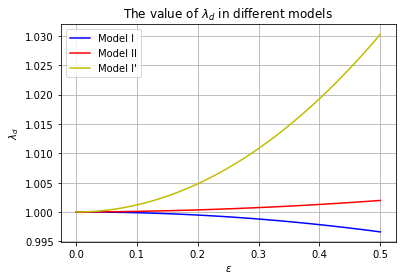

In [11]:
simuP(epsilonmax=0.5,T=1,nb=100)

# Second order effect

##  Model I':   Draw population model

In [12]:
def NVab(delta=1,T=10,epsilon=0.5):
    def f(t):
        return(np.cos(2*pi*t/T)) 
    def NVa(t):
        return(1+epsilon*f(t)*delta)
    def NVb(t):
        return(np.exp(epsilon*f(t)*delta))
    time=np.linspace(0,2*T,T*10)
    meanvb=integrate.quad(lambda t: NVb(t),0,T)[0]/T 
    NVa_value_av=np.zeros(len(time)) +integrate.quad(lambda t: NVa(t),0,T)[0]/T  
    NVb_value_av=np.zeros(len(time)) + meanvb
    NVa_value=np.zeros(len(time))
    NVb_value=np.zeros(len(time))
#    print("Gia tri cua tich phan",integrate.quad(lambda t: NVa(t),0,T)[0]/T)  #1+epsilon*f(t)*delta 
    for i in range(len(time)):
        NVa_value[i]=NVa(time[i])
        NVb_value[i]=NVb(time[i])
    plt.plot(time,NVa_value   ,"b-",label="$N_V^{(I)}$")
    plt.plot(time,NVa_value_av,"b--")# ,label="$<N_V^{(I)}>$"
    plt.plot(time,NVb_value   ,"y-",label="$N_V^{(I^{\prime})}$")
    plt.plot(time,NVb_value_av,"y--")#,label="$<N_V^{(I^{\prime})}>$"
    plt.annotate("$<N_V^{(I)}>= N_V(0)$", xy=(20, 1), xytext=(21, 1))   
#    plt.annotate("$<N_V^{(I)}>$", xy=(20, 1), xytext=(20, 1),   arrowprops=dict(arrowstyle="->"))    
    plt.annotate("$<N_V^{(I^{\prime})}>$", xy=(20, meanvb), xytext=(21, meanvb))    
#    plt.annotate("$<N_V^{(I^{\prime})}>$", xy=(20, meanvb), xytext=(21, meanvb),   arrowprops=dict(arrowstyle="->"))    
    plt.ylabel('$N_V(t)$')
    plt.xlabel('t')
#    plt.grid()
    plt.legend(loc=2)
    plt.xlim([0,2*T])
#    plt.title("The varying population in  : $\epsilon$=+str(epsilon) +str(, $\N_V$=1)")
#    plt.title("The total population for  $\epsilon$= "+str(epsilon)+str( ", $N_V(0) $=1, T=10,  f(t)=$\sin(2\pi t)$")  )
    plt.savefig("NVab.pdf", bbox_inches='tight')
    plt.savefig("NVab.jpg", bbox_inches='tight')

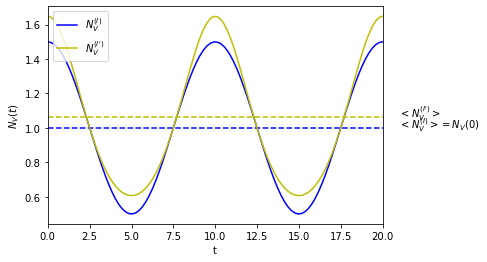

In [13]:
NVab(delta=1,T=10,epsilon=0.5)

# Vector population and $I_{H}$

Model
\begin{aligned}
    \frac{\text{d}S_H}{\text{d}t} &= \theta- a\beta_{VH} \frac{I_V S_H}{N_H} -\mu_{H}S_{H}=- a\beta_{VH} \frac{I_V S_H}{N_H} +\mu_{H}(I_{H} +R_{H}) ,\ \\
    \frac{\text{d}I_H}{\text{d}t} &= a \beta_{VH} \frac{I_V S_H}{N_H}- (\mu_H + r_H)
I_H ,\ \\
    \frac{\text{d}R_H}{\text{d}t} &= r_H I_H -\mu_H R_H,\  \\
    \frac{\text{d}S_V}{\text{d}t} &= \rho_V N_V - a \beta_{HV} I_H S_V - \mu_V S_V,\ \\
    \frac{\text{d}I_V}{\text{d}t} &= a \beta_{HV} I_H S_V -\mu_V I_V ,\
\end{aligned}
$\theta=\mu_{H}\left(S_{H}+I_{H}+R_{H}\right)$.

In the code of model, we assign, $a(t) $ represent for $a(t) \beta_{HV}$ and $ra=\beta_{VH}/\beta_{HV}$ therefore, $a(t)\beta_{VH} =ra .a(t)$

\begin{array}{rl}
NV1(t)	&= 1+c_{1}\epsilon f(t) = 1+\delta \epsilon f(t)\\
a(t)	&= 1+c_{2}\epsilon f(t)=1+b^\prime \epsilon f(t)\\
NV2 (t)	&=1+\exp \left( c_{1} \epsilon f(t) \right)
\end{array}

### Model $I^\prime$

#### $f(t)=\sin(2 \pi t/T)$

In [14]:
def Findlambdad(epsilon=1,muv=1,muh=1,delta=1,bprime=1,rh=1, T=1,a0=1,ra=2):
    def f(t):
        return(np.sin(2*pi*t/T))  
    def rho(t):                                                        # Malaria model 
        return(muv+epsilon*delta*w*(np.cos(w*t))/(1+epsilon*delta*np.sin(w*t)))
    def NV(t):
        return(1+epsilon*f(t)*delta)
    def a(t):
        return(a0*(1+epsilon*f(t)*bprime))        

    def msisi(x,t):   # The original system 
        return(ra*a(t)*x[1]-(muh+rh)*x[0],
               a(t)*x[0]*NV(t)-muv*x[1])

#    step=0.0005
#    time=np.arange(0,l*T,step)
#    timee=np.arange(l*T,k*T,step)
#    a_value=np.zeros(len(timee))
#    NV_value=np.zeros(len(timee))
#    for i in range(len(timee)):
#        a_value[i]=a(timee[i])
#        NV_value[i]=NV(timee[i])
    timerad=np.linspace(0,T,T*100)
    
    
# Compute the  the spectral radius of monodromy matrix
    in0=[1,0]
    sol0=np.array(odeint(msisi,in0,timerad))
    in1=[0,1]
    sol1=np.array(odeint(msisi,in1,timerad))
    E=np.array([sol0[-1],sol1[-1]])
    E=E.transpose()
    #print("R0",E)
    R0=spectralrad(E)
    return(R0)

## Recall that
$$R_{0}=\dfrac{a^{2}\beta_{VH}\beta_{HV}N_V }{\left( \mu_{H} +r_{H}\right)\mu_{V}}$$

In [15]:
FindlambdadModelIpr(epsilon=0,muv=1,muh=0.5,delta=1,bprime=0,rh=1.5, T=1,a0=1,ra=2)

0.9999999999999998

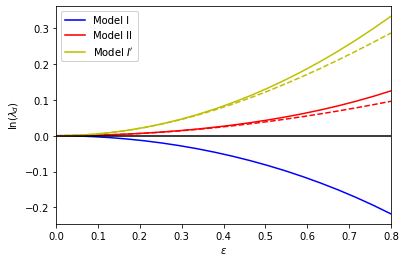

In [16]:
muv=1
muh=0.5

rh=1.5
T=5
a0=1
ra=2
fig,ax=plt.subplots()
epsilonmax=0.8
nb=20
epsl=np.linspace(0,epsilonmax,nb)
lbdavl  =np.zeros(nb)
lbdavlth=np.zeros(nb) # lambda_d by theory
cst1=(T/(2*pi))
cval=1+((muv+muh+rh)**2)*(cst1**2)
cst2=T*muv*(muh+rh)/(muv+muh+rh)


# Model 1 Vector population change 

delta=1
bprime=0
cst3=cst1**2* ((delta+bprime)*(muh+rh)-muv*bprime)*( (delta+bprime)*muv-bprime*(muh+rh))
cst=cst2*(delta*bprime/2-cst3/(2*cval)    )
#print(cst)

for i in range(nb):  # vector population change
#    lbdavl[i]=Findlambdad(epsilon=epsl[i],muv=muv,muh=muh,delta=delta,bprime=bprime,rh=rh, T=T,a0=a0,ra=ra)  # lambda value
#    lbdavlth[i]=1+cst*epsl[i]**2  # theory
    lbdavl[i]=np.log(Findlambdad(epsilon=epsl[i],muv=muv,muh=muh,delta=delta,bprime=bprime,rh=rh, T=T,a0=a0,ra=ra))  # lambda value
    lbdavlth[i]=np.log(1+cst*epsl[i]**2)  # theory
line1,= plt.plot(epsl,lbdavl,"b",label="Model I")
#line11,= plt.plot(epsl,lbdavl,"b",label="Numerical result")
#line2,= plt.plot(epsl,lbdavlth,'--b',label="Theoretical result")


# Model II Biting rate change. 

delta=0
bprime=1
cst3=cst1**2* ((delta+bprime)*(muh+rh)-muv*bprime)*( (delta+bprime)*muv-bprime*(muh+rh))
cst=cst2*(delta*bprime/2-cst3/(2*cval)    )
#print(cst)

for i in range(nb):  # vector population change
#    lbdavl[i]=Findlambdad(epsilon=epsl[i],muv=muv,muh=muh,delta=delta,bprime=bprime,rh=rh, T=T,a0=a0,ra=ra)  # lambda value
#    lbdavlth[i]=1+cst*epsl[i]**2  # theory
    lbdavl[i]=np.log(Findlambdad(epsilon=epsl[i],muv=muv,muh=muh,delta=delta,bprime=bprime,rh=rh, T=T,a0=a0,ra=ra))  # lambda value
    lbdavlth[i]=np.log(1+cst*epsl[i]**2)  # theory
line3,= plt.plot(epsl,lbdavl,"r",label="Model II")
line4,= plt.plot(epsl,lbdavlth,'--r',label="Theoretical")


# Model I'

delta=1
bprime=0
cst3=cst1**2* ((delta+bprime)*(muh+rh)-muv*bprime)*( (delta+bprime)*muv-bprime*(muh+rh))
cst=cst2*(delta**2/4+delta*bprime/2-cst3/(2*cval)    )
#print(cst)

for i in range(nb):  # vector population change
#    lbdavl[i]=FindlambdadModelIpr(epsilon=epsl[i],muv=muv,muh=muh,delta=delta,bprime=bprime,rh=rh, T=T,a0=a0,ra=ra)  # lambda value
#    lbdavlth[i]=1+cst*epsl[i]**2  # theory
    lbdavl[i]=np.log(FindlambdadModelIpr(epsilon=epsl[i],muv=muv,muh=muh,delta=delta,bprime=bprime,rh=rh, T=T,a0=a0,ra=ra))  # lambda value
    lbdavlth[i]=np.log(1+cst*epsl[i]**2)  # theory
line5,= plt.plot(epsl,lbdavl,"y",label="Model $I^\prime $")
line6,= plt.plot(epsl,lbdavlth,'--y',label="Theoretical")

#plt.xlim(0,0.5)
#plt.ylim(-0.01,0.04)
#plt.title("Effect of seasonality")


first_legend = plt.legend(handles=[line1,line3,line5], loc='upper left')
ax = plt.gca().add_artist(first_legend)
#plt.legend(handles=[line11,line2], loc='upper left')

yzero=np.zeros(len(epsl))

plt.plot(epsl,yzero,'k')

#plt.grid()
plt.xlabel("$\epsilon$")
plt.ylabel("$\ln(\lambda_{d})$")
plt.xlim([0,0.8])
#plt.axis('off')
plt.savefig("loglambda.pdf")

#### $f(t)=cos(2 \pi t/T)$

In [17]:
w=2*np.pi
l=100
k=l+2

In [18]:
def Findlambdadv2(epsilon=1,muv=1,muh=1,delta=1,bprime=1,rh=1, T=1,a0=1,ra=2):
    def f(t):
        return(np.cos(2*pi*t/T))  
    def rho(t):                                                        # Malaria model 
        return(muv-epsilon*delta*w*(np.sin(w*t))/(1+epsilon*delta*np.cos(w*t)))
    def NV(t):
        return(1+epsilon*f(t)*delta)
    def a(t):
        return(a0*(1+epsilon*f(t)*bprime))        

    def msisi(x,t):   # The original system 
        return(ra*a(t)*x[1]-(muh+rh)*x[0],
               a(t)*x[0]*NV(t)-muv*x[1])

#    step=0.0005
#    time=np.arange(0,l*T,step)
#    timee=np.arange(l*T,k*T,step)
#    a_value=np.zeros(len(timee))
#    NV_value=np.zeros(len(timee))
#    for i in range(len(timee)):
#        a_value[i]=a(timee[i])
#        NV_value[i]=NV(timee[i])
    timerad=np.linspace(0,T,T*100)
    
    
# Compute the  the spectral radius of monodromy matrix
    in0=[1,0]
    sol0=np.array(odeint(msisi,in0,timerad))
    in1=[0,1]
    sol1=np.array(odeint(msisi,in1,timerad))
    E=np.array([sol0[-1],sol1[-1]])
    E=E.transpose()
    #print("R0",E)
    R0=spectralrad(E)
    return(R0)

In [19]:
def FindlambdadModelIprv2(epsilon=1,muv=1,muh=1,delta=1,bprime=1,rh=1, T=1,a0=1,ra=2): # find \lambda_{d} of model I' 
    def f(t):
        return(np.cos(2*pi*t/T))  
    def rho(t):                                                        # Malaria model 
        return(muv-epsilon*delta*w*(np.sin(w*t))/(1+epsilon*delta*np.sin(w*t)))
    def NV(t):
#        return(1+epsilon*f(t)*delta)
        return(np.e**(epsilon*f(t)*delta))
    def a(t):
        return(a0*(1+epsilon*f(t)*bprime))        

    def msisi(x,t):   # The original system 
        return(ra*a(t)*x[1]-(muh+rh)*x[0],
               a(t)*x[0]*NV(t)-muv*x[1])

    step=0.0005
    time=np.arange(0,l*T,step)
    timee=np.arange(l*T,k*T,step)
    a_value=np.zeros(len(timee))
    NV_value=np.zeros(len(timee))
    for i in range(len(timee)):
        a_value[i]=a(timee[i])
        NV_value[i]=NV(timee[i])
    timerad=np.linspace(0,T,T*100)
    
    
# Compute the  the spectral radius of monodromy matrix
    in0=[1,0]
    sol0=np.array(odeint(msisi,in0,timerad))
    in1=[0,1]
    sol1=np.array(odeint(msisi,in1,timerad))
    E=np.array([sol0[-1],sol1[-1]])
    E=E.transpose()
    #print("R0",E)
    R0=spectralrad(E)
    return(R0)

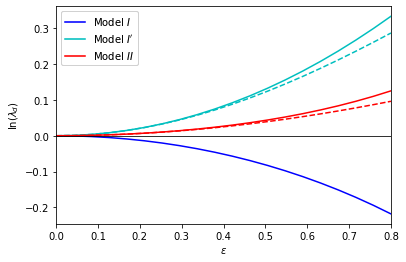

In [20]:
muv=1
muh=0.5

rh=1.5
T=5
a0=1
ra=2
fig,ax=plt.subplots()
epsilonmax=0.8
nb=20
epsl=np.linspace(0,epsilonmax,nb)
lbdavl  =np.zeros(nb)
lbdavlth=np.zeros(nb) # lambda_d by theory
cst1=(T/(2*pi))
cval=1+((muv+muh+rh)**2)*(cst1**2)
cst2=T*muv*(muh+rh)/(muv+muh+rh)


# Model 1 Vector population change 

delta=1
bprime=0
cst3=cst1**2* ((delta+bprime)*(muh+rh)-muv*bprime)*( (delta+bprime)*muv-bprime*(muh+rh))
cst=cst2*(delta*bprime/2-cst3/(2*cval)    )
#print(cst)

for i in range(nb):  # vector population change
#    lbdavl[i]=Findlambdad(epsilon=epsl[i],muv=muv,muh=muh,delta=delta,bprime=bprime,rh=rh, T=T,a0=a0,ra=ra)  # lambda value
#    lbdavlth[i]=1+cst*epsl[i]**2  # theory
    lbdavl[i]=np.log(Findlambdadv2(epsilon=epsl[i],muv=muv,muh=muh,delta=delta,bprime=bprime,rh=rh, T=T,a0=a0,ra=ra))  # lambda value
    lbdavlth[i]=np.log(1+cst*epsl[i]**2)  # theory
line1,= plt.plot(epsl,lbdavl,"b",label="Model $I$")
#line11,= plt.plot(epsl,lbdavl,"b",label="Numerical result")
#line2,= plt.plot(epsl,lbdavlth,'--b',label="Theoretical result")



# Model I'

delta=1
bprime=0
cst3=cst1**2* ((delta+bprime)*(muh+rh)-muv*bprime)*( (delta+bprime)*muv-bprime*(muh+rh))
cst=cst2*(delta**2/4+delta*bprime/2-cst3/(2*cval)    )
#print(cst)

for i in range(nb):  # vector population change
#    lbdavl[i]=FindlambdadModelIpr(epsilon=epsl[i],muv=muv,muh=muh,delta=delta,bprime=bprime,rh=rh, T=T,a0=a0,ra=ra)  # lambda value
#    lbdavlth[i]=1+cst*epsl[i]**2  # theory
    lbdavl[i]=np.log(FindlambdadModelIprv2(epsilon=epsl[i],muv=muv,muh=muh,delta=delta,bprime=bprime,rh=rh, T=T,a0=a0,ra=ra))  # lambda value
    lbdavlth[i]=np.log(1+cst*epsl[i]**2)  # theory
line5,= plt.plot(epsl,lbdavl,"c",label="Model $I^\prime $")
line6,= plt.plot(epsl,lbdavlth,'--c',label="Theoretical")

#plt.xlim(0,0.5)
#plt.ylim(-0.01,0.04)
#plt.title("Effect of seasonality")


# Model II Biting rate change. 

delta=0
bprime=1
cst3=cst1**2* ((delta+bprime)*(muh+rh)-muv*bprime)*( (delta+bprime)*muv-bprime*(muh+rh))
cst=cst2*(delta*bprime/2-cst3/(2*cval)    )
#print(cst)

for i in range(nb):  # vector population change
#    lbdavl[i]=Findlambdad(epsilon=epsl[i],muv=muv,muh=muh,delta=delta,bprime=bprime,rh=rh, T=T,a0=a0,ra=ra)  # lambda value
#    lbdavlth[i]=1+cst*epsl[i]**2  # theory
    lbdavl[i]=np.log(Findlambdadv2(epsilon=epsl[i],muv=muv,muh=muh,delta=delta,bprime=bprime,rh=rh, T=T,a0=a0,ra=ra))  # lambda value
    lbdavlth[i]=np.log(1+cst*epsl[i]**2)  # theory
line3,= plt.plot(epsl,lbdavl,"r",label="Model $II$")
line4,= plt.plot(epsl,lbdavlth,'--r',label="Theoretical")



first_legend = plt.legend(handles=[line1,line5,line3], loc='upper left')
ax = plt.gca().add_artist(first_legend)
#plt.legend(handles=[line11,line2], loc='upper left')

yzero=np.zeros(len(epsl))

plt.plot(epsl,yzero,'k',linewidth=0.8)

#plt.grid()
plt.xlabel("$\epsilon$")
plt.ylabel("$\ln(\lambda_{d})$")
plt.xlim([0,0.8])
#plt.axis('off')
plt.savefig("loglambda.pdf")